In [12]:
import os
import cv2 # type: ignore
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:

from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
def quantify_image(image):
    # Check if the input image has only one channel
    if len(image.shape) == 2:
        # If it has only one channel, it's already grayscale
        gray = image
    else:
        # If it has multiple channels, convert it to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply other preprocessing steps and feature extraction
    gray = cv2.resize(gray, (200, 200))
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    features = feature.hog(thresh, orientations=9, pixels_per_cell=(10, 10),
                           cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
    return features


In [15]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

In [16]:
def train_models(dataset):
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }
    # define the path to the testing and training directories
    path = "E:/FINALPROJECT DATASET/archive (17)/" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    # train each model and calculate its metrics
    for model in models:
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)

    return models


In [17]:
# Train the models on the spiral drawings
spiralModels = train_models("spiral")

In [18]:
waveModels = train_models('wave')

In [19]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=86.67%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=80.00%, XGBoost=73.33% 

Specificity: 
Random Forrest=93.33%, XGBoost=73.33% 



In [20]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=76.67%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=73.33%, XGBoost=80.00% 

Specificity: 
Random Forrest=80.00%, XGBoost=66.67% 



# Testing On Sample Images and Visualize the predictions

In [21]:
def test_prediction(model, testingPath):
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # Preprocess the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # Quantify the image
        features = quantify_image(image)
        # Make predictions based on the extracted features
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"
        # Draw the class label on the output image
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

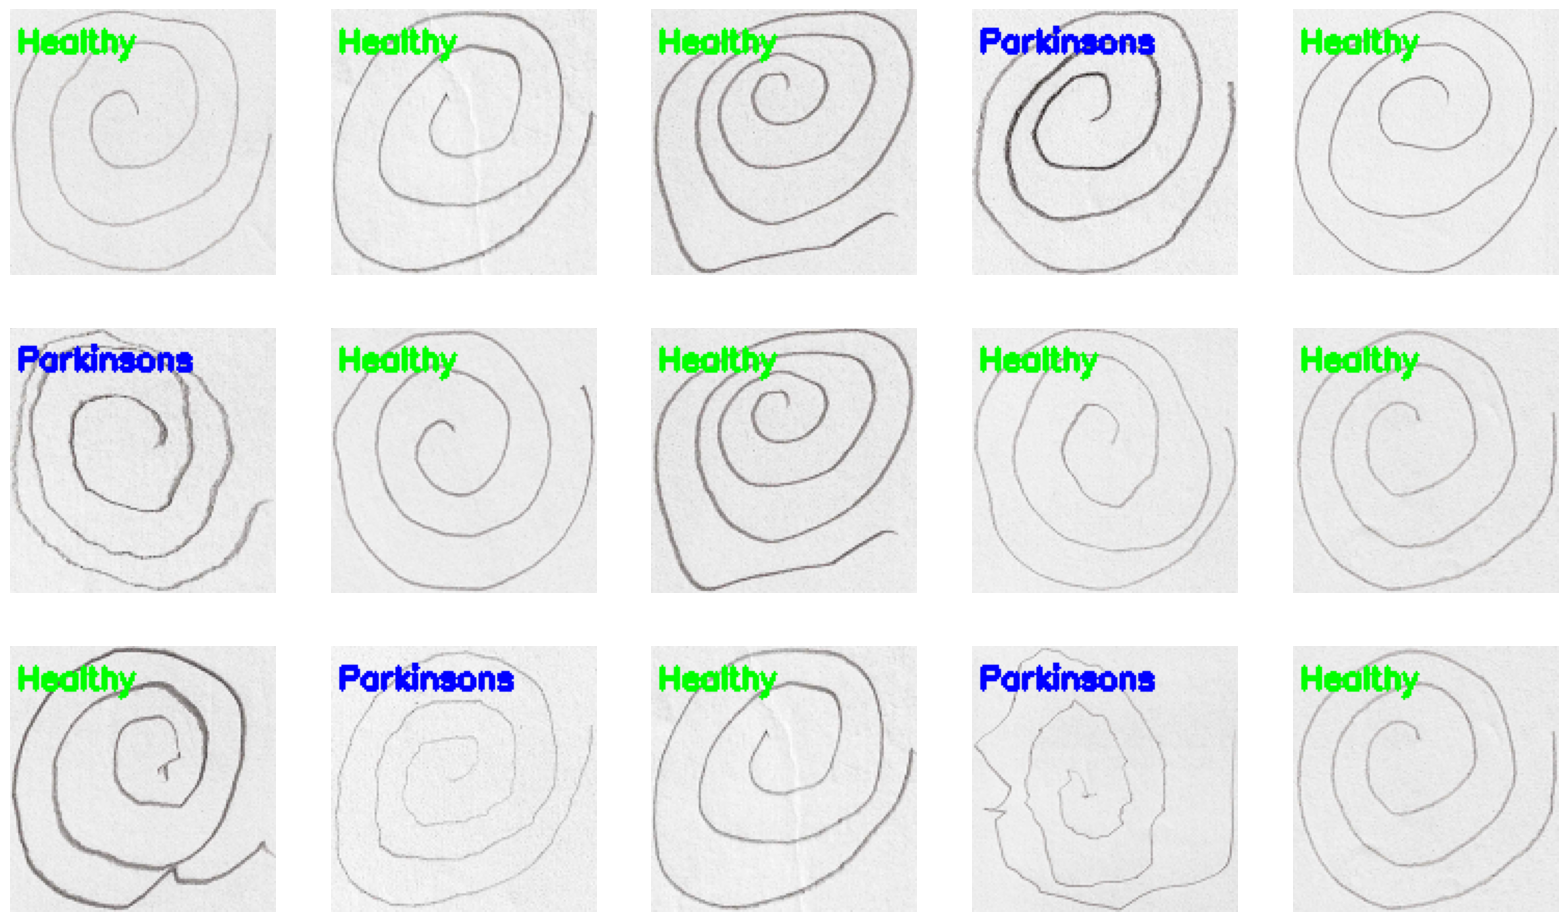

In [22]:
testingPath = os.path.sep.join(["E:/FINALPROJECT DATASET/archive (17)/spiral", "testing"])
test_prediction(spiralModels['Rf']['classifier'], testingPath)

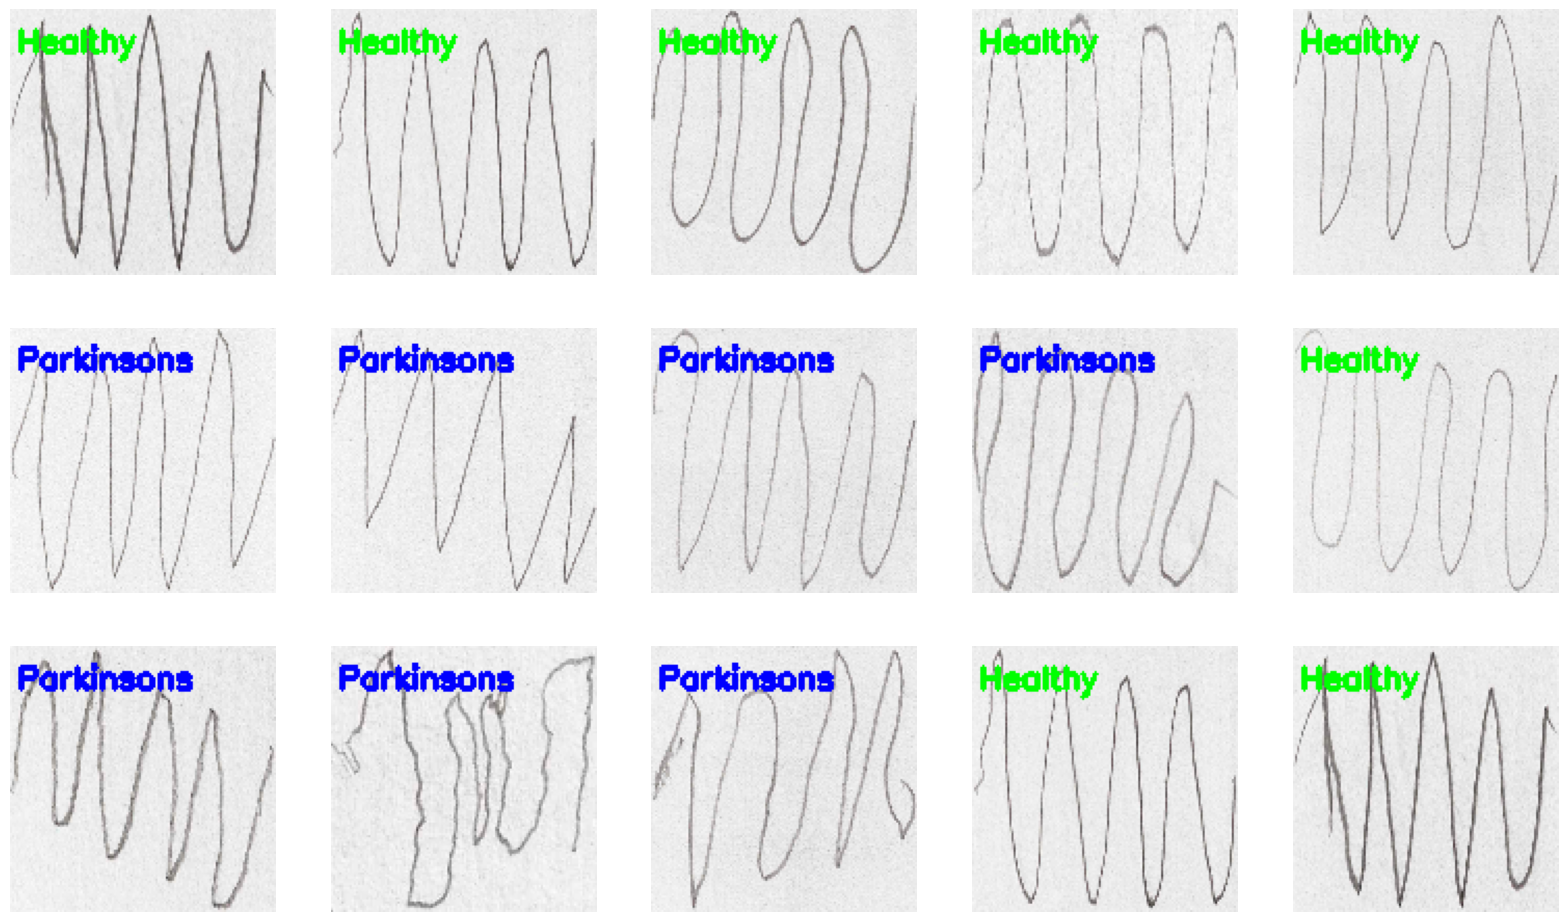

In [23]:
testingPath = os.path.sep.join(["E:/FINALPROJECT DATASET/archive (17)/wave", "testing"])
test_prediction(waveModels['Rf']['classifier'], testingPath)

In [24]:
import joblib
# import tensorflow as tf

# Save the trained models to .pkl files
joblib.dump(spiralModels['Rf']['classifier'], 'spiral_rf_model_four.pkl')


['spiral_rf_model_four.pkl']

In [25]:
import joblib
# import tensorflow as tf

# Save the trained models to .pkl files
joblib.dump(waveModels['Rf']['classifier'], 'wave_rf_model.pkl')


['wave_rf_model.pkl']

In [14]:
joblib.dump(spiralModels['Xgb']['classifier'], 'spiral_xgb_model.h5')

['spiral_xgb_model.h5']

In [15]:
joblib.dump(waveModels['Rf']['classifier'], 'wave_rf_model.h5')

['wave_rf_model.h5']

In [16]:
joblib.dump(waveModels['Xgb']['classifier'], 'wave_xgb_model.h5')

['wave_xgb_model.h5']

In [17]:
# Function to test predictions on sample images and visualize the results
def test_prediction(model, testingPath):
    # Get the list of images
    testingPaths = os.listdir(testingPath)
    output_images = []
    # Pick 15 images at random
    for _ in range(15):
        image_filename = random.choice(testingPaths)
        image_path = os.path.join(testingPath, image_filename)
        print("Image Path:", image_path)  # Debugging print statement
        image = cv2.imread(image_path)
        if image is None:
            print("Failed to read image:", image_path)  # Debugging print statement
            continue
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # Pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # Quantify the image and make predictions based on the extracted features
        features = quantify_image(image)  # Assuming you have a function to extract features
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        # Draw the colored class label on the output image and add it to the set of output images
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        output_images.append(output)

    # Visualize the output images
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()




In [18]:

# Test predictions on wave images
wave_testing_path = "C:/Users/jayas/Downloads/Parkinsons disease detection/spiral and wave/wave/testing"
test_prediction(waveModels['Rf']['classifier'], wave_testing_path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/jayas/Downloads/Parkinsons disease detection/spiral and wave/wave/testing'

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

: 

In [ ]:
def test_single_image_prediction(model_path, image_path):
    try:
        # Load the model
        model = load_model(model_path)
    except FileNotFoundError:
        print("Error: Model file not found at the specified path.")
        return
    except Exception as e:
        print(f"Error: Failed to load the model. {e}")
        return
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Failed to read the image.")
        return

    # Copy the image for visualization
    output = image.copy()
    output = cv2.resize(output, (128, 128))

    # Pre-process the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Quantify the image and make predictions based on the extracted features
    features = quantify_image(image)  # Assuming you have a function to extract features
    preds = model.predict([features])
    label = "Parkinsons" if preds[0] else "Healthy"

    # Draw the colored class label on the output image
    color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
    cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Visualize the output image
    cv2.imshow("Prediction", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Test predictions on a single image
model_path = "C:/Users/jayas/Downloads/Parkinsons disease detection/spiral and wave/spiral_rf_model.h5"
image_path = "C:/Users/jayas/Downloads/Parkinsons disease detection/spiral and wave/spiral/testing/parkinson/V02PE01.png"
test_single_image_prediction(model_path, image_path)

: 

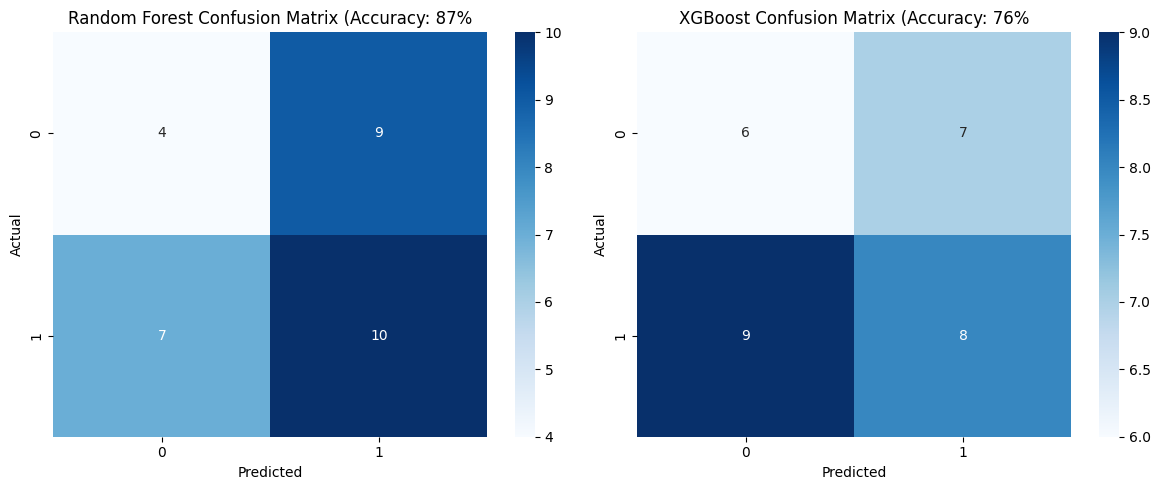

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming you have the true labels and predicted labels for each classifier
# Let's create some sample data for confusion matrices and accuracies
# You'd replace this with your actual true and predicted labels
np.random.seed(0)
y_true = np.random.choice([0, 1], 30)
y_pred_rf = np.random.choice([0, 1], 30)
y_pred_xgb = np.random.choice([0, 1], 30)

# Compute confusion matrices for Random Forest and XGBoost
cm_rf = confusion_matrix(y_true, y_pred_rf)
cm_xgb = confusion_matrix(y_true, y_pred_xgb)

# Calculate accuracy for Random Forest and XGBoost
accuracy_rf = accuracy_score(y_true, y_pred_rf)
accuracy_xgb = accuracy_score(y_true, y_pred_xgb)

# Create subplots to plot both confusion matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Random Forest with accuracy in the title
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title(f"Random Forest Confusion Matrix (Accuracy: 87%)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

# Plot for XGBoost with accuracy in the title
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title(f"XGBoost Confusion Matrix (Accuracy: 76%)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

# Layout adjustment for better visual appeal
plt.tight_layout()
plt.show()
